In [ ]:
def pearson_correlation_scatterplot(df, cols,
                                    title= "Pearson Correlation Scatterplot",
                                    xlabel= None, ylabel = None):
    """
    Creates a scatterplot for two specified columns from the DataFrame,
    calculates the Pearson correlation coefficient, and displays the plot.

    Parameters:
      df : pd.DataFrame
          The input DataFrame containing the data.
      cols : list
          List of two column names (as strings) for which the scatterplot and correlation
          coefficient will be computed.
      title : str, optional
          The title for the scatterplot. Default is "Pearson Correlation Scatterplot".
      xlabel : str, optional
          Label for the x-axis. If None, the first column name from cols is used.
      ylabel : str, optional
          Label for the y-axis. If None, the second column name from cols is used.

    Returns:
      corr_coef : float
          The computed Pearson correlation coefficient.
      p_value : float
          The p-value for testing non-correlation.
    """
    if len(cols) != 2:
        raise ValueError("Exactly two columns must be provided for Pearson correlation.")

    x_col, y_col = cols
    x = df[x_col]
    y = df[y_col]

    # Calculate the Pearson correlation coefficient and p-value.
    corr_coef, p_value = pearsonr(x, y)

    # Setup axis labels if not provided.
    if xlabel is None:
        xlabel = x_col
    if ylabel is None:
        ylabel = y_col

    # Create scatter plot.
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.7, c='blue', edgecolors='w', s=100)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Display the correlation coefficient on the plot.
    plt.text(0.05, 0.95, f"Pearson r = {corr_coef:.3f}\np-value = {p_value:.3g}",
             transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return corr_coef, p_value

In [ ]:
def spearman_correlation_scatterplot(df, cols,
                                    title= "spearman rank Correlation Scatterplot",
                                    xlabel= None, ylabel = None):
    """
    Creates a scatterplot for two specified columns from the DataFrame,
    calculates the Spearman's rank correlation coefficient, and displays the plot.

    Parameters:
      df : pd.DataFrame
          The input DataFrame containing the data.
      cols : list
          List of two column names (as strings) for which the scatterplot and correlation
          coefficient will be computed.
      title : str, optional
          The title for the scatterplot. Default is "Spearman Rank Correlation Scatterplot".
      xlabel : str, optional
          Label for the x-axis. If None, the first column name from cols is used.
      ylabel : str, optional
          Label for the y-axis. If None, the second column name from cols is used.

    Returns:
      corr_coef : float
          The computed Spearman rank correlation coefficient.
      p_value : float
          The p-value for testing non-correlation.
    """
    if len(cols) != 2:
        raise ValueError("Exactly two columns must be provided for Spearman correlation.")

    x_col, y_col = cols
    x = df[x_col]
    y = df[y_col]

    # Calculate Spearman's rank correlation coefficient and corresponding p-value.
    corr_coef, p_value = spearmanr(x, y)

    # Setup axis labels if not provided.
    if xlabel is None:
        xlabel = x_col
    if ylabel is None:
        ylabel = y_col

    # Create scatter plot.
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.7, c='green', edgecolors='w', s=100)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Display the correlation coefficient on the plot.
    plt.text(0.05, 0.95, f"Spearman r = {corr_coef:.3f}\np-value = {p_value:.3g}",
             transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor="lavender", alpha=0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return corr_coef, p_value

In [ ]:
def extract_and_upweight_visits(df):
    df["POPULARITY_BY_DAY"] = df["POPULARITY_BY_DAY"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Extract weekday and weekend visits
    df["weekday_visits"] = df["POPULARITY_BY_DAY"].apply(lambda x: sum([x.get(day, 0) for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]))
    df["weekend_visits"] = df["POPULARITY_BY_DAY"].apply(lambda x: sum([x.get(day, 0) for day in ["Saturday", "Sunday"]]))

    # Multiply by upweighting_factor
    #df["weekday_visits"] *= df["upweighting_factor"]
    #df["weekend_visits"] *= df["upweighting_factor"]

    return df

In [ ]:
!git clone https://github.com/comradeshawty/patterns.git
%cd patterns

Cloning into 'patterns'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 360 (delta 36), reused 0 (delta 0), pack-reused 296 (from 2)
Receiving objects: 100% (360/360), 2.27 MiB | 3.02 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/patterns


In [ ]:
def compute_income_segregation(df, cbg_gdf):
    """
    For each POI (i.e. each row in df), compute an income segregation score
    based on the processed visitor counts, and compute experienced income segregation for each CBG.

    The function maps each CBG (key in the processed dict) to an income quartile
    (using cbg_income_map, which maps CBG (as int) to a quartile in {1,2,3,4}),
    sums the visitor counts by quartile per POI, and then calculates the POI segregation
    measure as:

         segregation = (2/3) * sum(|proportion - 0.25|)

    where the proportion is the fraction of visitors from each quartile at that POI.

    In addition, we compute the experienced income segregation for each CBG.
    For each POI (denoted by α):
      - τ₍q,α₎: the proportion of time at place α spent by income group q.
      - For each CBG b visiting that POI, τ₍b,α₎ is calculated as the count for b at α divided by
        the total visitors at α, but then normalized across all POIs (i.e. divided by the CBG's global total visits).
    Then, for each CBG, the relative exposure is:
         τ₍b,q₎ = Σ₍α visited by b₎ (τ₍b,α₎ * τ₍q,α₎)
    and the experienced income segregation measure is:
         Sᵢ = (2/3) * Σ₍q=1...4₎ |τ₍b,q₎ − 0.25|

    Additionally, this function adds a column to df named 'quartile_proportions'
    which contains, for each POI, a dictionary with the proportions of visitors from each income quartile.
    The dictionary is formatted as: {'low': prop, 'lower_middle': prop, 'upper_middle': prop, 'high': prop}

    Parameters:
      df     : DataFrame that includes the 'adjusted_cbg_visitors' column containing the processed visitor counts.
      cbg_gdf: GeoDataFrame with CBG information and an 'income_quantile' column;
               the income labels for CBGs are in {"low", "lower_middle", "upper_middle", "high"}.

    Returns:
      Tuple: (df with added columns 'income_segregation' and 'quartile_proportions',
              updated cbg_gdf with column 'experienced_income_segregation')
    """
    income_label_to_quartile = {"low": 1, "lower_middle": 2, "upper_middle": 3, "high": 4}

    # Ensure CBGs in cbg_gdf are correctly formatted.
    cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)

    # Create mapping: CBG → Income Quartile.
    cbg_income_map = cbg_gdf.set_index("cbg")["income_quantile"].map(income_label_to_quartile).to_dict()

    def segregation_from_dict(visitor_dict):
        """
        Compute the POI-level income segregation score along with the distribution of visitor proportions by quartile.
        Returns a tuple: (segregation score, proportions array, proportions dictionary, total visitors at the POI).
        """
        quartile_counts = np.zeros(4, dtype=float)
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            quartile = cbg_income_map.get(cbg_int, None)
            if quartile is not None:
                quartile_counts[quartile - 1] += count  # store in 0-based index.

        total = quartile_counts.sum()
        if total == 0:
            default_proportions = {"low": 0, "lower_middle": 0, "upper_middle": 0, "high": 0}
            return np.nan, None, default_proportions, total

        proportions = quartile_counts / total  # Fraction for each quartile.
        segregation = (2/3) * np.sum(np.abs(proportions - 0.25))
        proportions_dict = {
            "low": proportions[0],
            "lower_middle": proportions[1],
            "upper_middle": proportions[2],
            "high": proportions[3]
        }
        return segregation, proportions, proportions_dict, total

    # Compute POI-level segregation scores and prepare for CBG-level aggregation.
    poi_segregation_scores = []         # Holds segregation score for each POI.
    quartile_proportions_list = []        # Holds the proportions dictionary for each POI.

    # Dictionary to hold total visits per CBG across all POIs.
    total_visits_per_cbg = {}
    # Dictionary to accumulate exposure contributions per CBG; key: cbg, value: np.array (length 4)
    cbg_exposure = {}

    # First pass: calculate global total visits for each CBG across all POIs.
    for idx, row in df.iterrows():
        visitor_dict = row['adjusted_cbg_visitors']
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            total_visits_per_cbg[cbg_int] = total_visits_per_cbg.get(cbg_int, 0) + count

    # Second pass: compute each POI's quartile proportions and accumulate CBG exposure contributions.
    for idx, row in df.iterrows():
        visitor_dict = row['adjusted_cbg_visitors']
        segregation_value, proportions, proportions_dict, total_alpha = segregation_from_dict(visitor_dict)

        poi_segregation_scores.append(segregation_value)
        quartile_proportions_list.append(proportions_dict)

        # For each CBG present in the POI, compute its weight for this POI and add its exposure contribution.
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            global_total = total_visits_per_cbg.get(cbg_int, 0)
            if global_total == 0 or proportions is None:
                continue
            # τ₍b,α₎: fraction of the CBG's visits that occur at this POI.
            tau_b_alpha = count / global_total
            contribution = tau_b_alpha * proportions
            if cbg_int in cbg_exposure:
                cbg_exposure[cbg_int] += contribution
            else:
                cbg_exposure[cbg_int] = np.array(contribution, dtype=float)

    # Add the computed POI-level income segregation scores and quartile proportions as new columns in df.
    df = df.copy()
    df['Sα'] = poi_segregation_scores
    df['quartile_proportions'] = quartile_proportions_list

    # Compute experienced income segregation for each CBG and add it to the cbg_gdf.
    experienced_income_segregation = {}
    for cbg, exposure_array in cbg_exposure.items():
        exposure_sum = exposure_array.sum()
        if exposure_sum == 0:
            experienced_income_segregation[cbg] = np.nan
        else:
            normalized_exposure = exposure_array / exposure_sum
            experienced_income_segregation[cbg] = (2/3) * np.sum(np.abs(normalized_exposure - 0.25))

    cbg_gdf = cbg_gdf.copy()
    cbg_gdf['Si'] = cbg_gdf['cbg'].map(experienced_income_segregation)

    return df, cbg_gdf

In [ ]:
def merge_2010_to_2020_block_groups(expanded_df, crosswalk_df, cbg_col='cbg'):
    expanded_df=expanded_df.merge(crosswalk_df,left_on=cbg_col,right_on='bg2010ge',how='left')
    expanded_df.rename(columns={'bg2020ge':'cbg_2020'},inplace=True)
    if 'geometry' in expanded_df.columns:
        expanded_df = gpd.GeoDataFrame(expanded_df, geometry='geometry', crs="EPSG:4326")

    return expanded_df

In [ ]:
def extract_unique_cbg_keys(df):
    """
    Given a DataFrame with an 'adjusted_cbg_visitors' column (with dictionaries as values),
    extract a set of unique CBG keys (as integers) across all rows.
    """
    unique_keys = set()
    for visitors in df['adjusted_cbg_visitors']:
        # Convert each key to int before adding
        for key in visitors.keys():
            try:
                unique_keys.add(int(key))
            except ValueError:
                continue
    return unique_keys

def count_common_cbgs(cbg_gdf,crosswalk_df, unique_cbg_keys):
    """
    Count how many CBGs in the 'cbg' column of cbg_gdf (converted to integers)
    are also in unique_cbg_keys.
    """
    # Ensure that the cbg column is converted to integers.
    cbg_set = set(cbg_gdf['cbg'].astype(int))
    cbg_2020_set=set(crosswalk_df['GEOID_BLKGRP_20'].astype(int))
    common = cbg_set.intersection(cbg_2020_set)
    common_2020 = unique_cbg_keys.intersection(cbg_2020_set)
    return len(common), common,common_2020,len(common_2020)

In [ ]:
def compute_quintile_income_segregation(df, cbg_gdf):
    """
    For each POI (i.e. each row in df), compute an income segregation score
    based on the processed visitor counts, and compute experienced income segregation for each CBG.

    The function maps each CBG (key in the processed dict) to an income quintile
    (using cbg_income_map, which maps CBG (as int) to a quartile in {1,2,3,4,5}),
    sums the visitor counts by quartile per POI, and then calculates the POI segregation
    measure as:

         segregation = (5/8) * sum(|proportion - 0.2|)

    where the proportion is the fraction of visitors from each quartile at that POI.

    In addition, we compute the experienced income segregation for each CBG.
    For each POI (denoted by α):
      - τ₍q,α₎: the proportion of time at place α spent by income group q.
      - For each CBG b visiting that POI, τ₍b,α₎ is calculated as the count for b at α divided by
        the total visitors at α, but then normalized across all POIs (i.e. divided by the CBG's global total visits).
    Then, for each CBG, the relative exposure is:
         τ₍b,q₎ = Σ₍α visited by b₎ (τ₍b,α₎ * τ₍q,α₎)
    and the experienced income segregation measure is:
         Sᵢ = (5/8) * Σ₍q=1...5₎ |τ₍b,q₎ − 0.2|

    Additionally, this function adds a column to df named 'quintile_proportions'
    which contains, for each POI, a dictionary with the proportions of visitors from each income quintile.
    The dictionary is formatted as: {'low': prop, 'lower_middle': prop, 'middle':prop,'upper_middle': prop, 'high': prop}

    Parameters:
      df     : DataFrame that includes the 'adjusted_cbg_visitors' column containing the processed visitor counts.
      cbg_gdf: GeoDataFrame with CBG information and an 'income_quintile' column;
               the income labels for CBGs are in {"low", "lower_middle", "middle","upper_middle", "high"}.

    Returns:
      Tuple: (df with added columns 'quintile_income_segregation' and 'quintile_proportions',
              updated cbg_gdf with column 'experienced_income_segregation')
    """
    income_label_to_quintile = {"low": 1, "lower_middle": 2,"middle":3, "upper_middle": 4, "high": 5}

    # Ensure CBGs in cbg_gdf are correctly formatted.
    cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)

    # Create mapping: CBG → Income Quartile.
    cbg_income_map = cbg_gdf.set_index("cbg")["income_quintile"].map(income_label_to_quintile).to_dict()

    def segregation_from_dict(visitor_dict):
        """
        Compute the POI-level income segregation score along with the distribution of visitor proportions by quartile.
        Returns a tuple: (segregation score, proportions array, proportions dictionary, total visitors at the POI).
        """
        quintile_counts = np.zeros(5, dtype=float)
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            quintile = cbg_income_map.get(cbg_int, None)
            if quintile is not None:
                quintile_counts[quintile - 1] += count  # store in 0-based index.

        total = quintile_counts.sum()
        if total == 0:
            default_proportions = {"low": 0, "lower_middle": 0, "middle":0,"upper_middle": 0, "high": 0}
            return np.nan, None, default_proportions, total

        proportions = quintile_counts / total  # Fraction for each quartile.
        segregation = (5/8) * np.sum(np.abs(proportions - 0.2))
        proportions_dict = {
            "low": proportions[0],
            "lower_middle": proportions[1],
            "middle":proportions[2],
            "upper_middle": proportions[3],
            "high": proportions[4]
        }
        return segregation, proportions, proportions_dict, total

    # Compute POI-level segregation scores and prepare for CBG-level aggregation.
    poi_segregation_scores = []         # Holds segregation score for each POI.
    quintile_proportions_list = []        # Holds the proportions dictionary for each POI.

    # Dictionary to hold total visits per CBG across all POIs.
    total_visits_per_cbg = {}
    # Dictionary to accumulate exposure contributions per CBG; key: cbg, value: np.array (length 5)
    cbg_exposure = {}

    # First pass: calculate global total visits for each CBG across all POIs.
    for idx, row in df.iterrows():
        visitor_dict = row['adjusted_cbg_visitors']
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            total_visits_per_cbg[cbg_int] = total_visits_per_cbg.get(cbg_int, 0) + count

    # Second pass: compute each POI's quartile proportions and accumulate CBG exposure contributions.
    for idx, row in df.iterrows():
        visitor_dict = row['adjusted_cbg_visitors']
        segregation_value, proportions, proportions_dict, total_alpha = segregation_from_dict(visitor_dict)

        poi_segregation_scores.append(segregation_value)
        quintile_proportions_list.append(proportions_dict)

        # For each CBG present in the POI, compute its weight for this POI and add its exposure contribution.
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            global_total = total_visits_per_cbg.get(cbg_int, 0)
            if global_total == 0 or proportions is None:
                continue
            # τ₍b,α₎: fraction of the CBG's visits that occur at this POI.
            tau_b_alpha = count / global_total
            contribution = tau_b_alpha * proportions
            if cbg_int in cbg_exposure:
                cbg_exposure[cbg_int] += contribution
            else:
                cbg_exposure[cbg_int] = np.array(contribution, dtype=float)

    # Add the computed POI-level income segregation scores and quartile proportions as new columns in df.
    df = df.copy()
    df['Sα_q'] = poi_segregation_scores
    df['quintile_proportions'] = quintile_proportions_list

    # Compute experienced income segregation for each CBG and add it to the cbg_gdf.
    experienced_income_segregation = {}
    for cbg, exposure_array in cbg_exposure.items():
        exposure_sum = exposure_array.sum()
        if exposure_sum == 0:
            experienced_income_segregation[cbg] = np.nan
        else:
            normalized_exposure = exposure_array / exposure_sum
            experienced_income_segregation[cbg] = (5/8) * np.sum(np.abs(normalized_exposure - 0.2))

    cbg_gdf = cbg_gdf.copy()
    cbg_gdf['Si_q'] = cbg_gdf['cbg'].map(experienced_income_segregation)

    return df, cbg_gdf

In [ ]:
def compute_residential_income_segregation(cbg_gdf):
    """
    Computes S_res (residential income segregation) for each CBG using
    fixed bracket definitions for 'low', 'lower_middle', 'upper_middle', 'high'.

    Each row of cbg_gdf is expected to have columns representing the
    number of households in these brackets:
      'less_than_10k', '10k_15k', '15k_to_20k', '20k_to_25k', '25k_to_30k',
      '30k_to_35k', '35k_to_40k', '40k_to_45k', '45k_to_50k', '50k_to_60k',
      '60k_to_75k', '75k_to_100k', '100k_to_125k', '125k_to_150k',
      '150k_to_200k', '200k_or_more'.

    The category definitions (from bracket to income group) are:
      low =  { 'less_than_10k', '10k_15k', '15k_to_20k' }
      lower_middle = { '20k_to_25k', '25k_to_30k', '30k_to_35k', '35k_to_40k', '40k_to_45k', '45k_to_50k' }
      upper_middle = { '50k_to_60k', '60k_to_75k', '75k_to_100k' }
      high = { '100k_to_125k', '125k_to_150k', '150k_to_200k', '200k_or_more' }

    We define the segregation measure using four quartiles:
      S_res = (2/3) * sum( | proportion_in_quartile - 0.25 | ) over all quartiles.

    Parameters
    ----------
    cbg_gdf : DataFrame (or GeoDataFrame)
        Must have the columns for each bracket listed above.

    Returns
    -------
    cbg_gdf : DataFrame (copy)
        A modified copy of the original with an added column "S_res" that holds
        the computed segregation measure per CBG.
    """

    # Mapping from bracket columns to quartile category
    bracket_map = {
        'low': ['less_than_10k', '10k_15k', '15k_to_20k'],
        'lower_middle': ['20k_to_25k', '25k_to_30k', '30k_to_35k','35k_to_40k', '40k_to_45k', '45k_to_50k'],
        'upper_middle': ['50k_to_60k', '60k_to_75k', '75k_to_100k'],
        'high': ['100k_to_125k', '125k_to_150k','150k_to_200k', '200k_or_more']}

    def compute_s_res_for_row(row):
        q_pops = []
        total_pop = 0.0
        for category in ['low', 'lower_middle', 'upper_middle', 'high']:
            cat_sum = 0.0
            for bracket_col in bracket_map[category]:
                cat_sum += float(row.get(bracket_col, 0.0))
            q_pops.append(cat_sum)
            total_pop += cat_sum

        if total_pop == 0:
            return np.nan

        proportions = [pop / total_pop for pop in q_pops]
        s_res = (2.0 / 3.0) * sum(abs(p - 0.25) for p in proportions)
        return s_res

    new_gdf = cbg_gdf.copy()
    new_gdf["S_res"] = new_gdf.apply(compute_s_res_for_row, axis=1)
    new_gdf.dropna(subset=['Si','S_res'],inplace=True,ignore_index=True)
    return new_gdf

In [ ]:
def compute_place_entropy(df, cbg_gdf):
    """
    For each place (each row in df), compute an entropy measure Hₐ that quantifies
    the unevenness of the distribution of visitor groups (income quartiles in this case).

    The entropy is defined as:

         Hₐ = - ( Σ₍q=1 to 4₎ τ₍q,α₎ log(τ₍q,α₎) ) / log(4)

    where τ₍q,α₎ is the fraction of visitors at place α from income quartile q.
    When the groups are equally present (τ = 1/4 for every group), then Hₐ = 1.
    When only one group visits (one τ is 1 and the rest 0), then Hₐ = 0.

    This function adapts the compute_income_segregation function from income_segregation.py
    by aggregating visitor counts (from the 'adjusted_cbg_visitors' column in df) by
    the income quartile of each CBG (based on the cbg_gdf's 'income_quantile' column) and
    computing the entropy of the distribution.

    Parameters:
      df     : DataFrame that includes the column 'adjusted_cbg_visitors' where each value
               is a dictionary mapping CBG (as a string or int) to visitor counts.
      cbg_gdf: DataFrame (or GeoDataFrame) with CBG information, including at least two columns:
               - 'cbg': unique identifier for each CBG.
               - 'income_quantile': income quartile label, one of {"low", "lower_middle", "upper_middle", "high"}.

    Returns:
      df : A copy of the original df with an added column 'entropy_measure' containing Hₐ for each place.
    """
    income_label_to_quartile = {
        "low": 1,
        "lower_middle": 2,
        "upper_middle": 3,
        "high": 4
    }

    cbg_gdf = cbg_gdf.copy()
    cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)

    cbg_income_map = cbg_gdf.set_index("cbg")["income_quantile"].map(income_label_to_quartile).to_dict()

    def entropy_from_dict(visitor_dict):
        """
        For a given visitor dictionary from adjusted_cbg_visitors, aggregate visitor counts by income quartile,
        compute the quantified proportions, and then calculate the entropy measure Hₐ.
        """
        quartile_counts = np.zeros(4, dtype=float)  # indices 0 through 3 correspond to quartiles 1 to 4
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            quartile = cbg_income_map.get(cbg_int, None)
            if quartile is not None:
                quartile_counts[quartile - 1] += count

        total = quartile_counts.sum()
        if total == 0:
            return np.nan

        # Compute proportions τ₍q,α₎ for each quartile
        proportions = quartile_counts / total

        # Compute the entropy measure
        # Handle p = 0 by using 0 * log(p) = 0.
        entropy_sum = 0.0
        for p in proportions:
            if p > 0:
                entropy_sum += p * np.log(p)
        # Normalize entropy to be between 0 and 1.
        H = - entropy_sum / np.log(4)
        return H

    # Compute the entropy measure for each place (i.e. each row in df)
    df = df.copy()
    df["Hα"] = df["adjusted_cbg_visitors"].apply(entropy_from_dict)
    return df

In [ ]:
def compute_out_of_cbg_visitors(mp):
  def calc_out_of_cbg_visitors(row):
          visitors = row.get('adjusted_cbg_visitors', {})
          # Ensure the POI_CBG is treated as a string for comparison
          poi_cbg = str(row.get('POI_CBG', ''))
          total = 0
          for cbg, count in visitors.items():
              # Compare keys as strings to ensure consistency
              if str(cbg) != poi_cbg:
                  total += count
          return total
  mp = mp.copy()
  mp['out_of_cbg_visitors'] = mp.apply(calc_out_of_cbg_visitors, axis=1)
  return mp

In [ ]:
!pip install gtfs_kit

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 722.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 5.8 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7594 sha256=8418376d7a6c9d1ce2193a553ef01b2fa30b7f5c01fc8fe0e395988eb5aa23c8
  Stored in directory: /root/.cache/pip/wheels/ea/8b/96/b33d26a9d72d6c8ac50ef1fe81089c350a9fdcf51feab22144
Successfully built json2html


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import random
import geopandas as gpd
from shapely.geometry import Polygon,Point
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from collections import Counter
import math
from scipy.spatial import cKDTree
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import ast
from ast import literal_eval
from cbgs_processor import compute_racial_weighted_mean,compute_income_weighted_mean,compute_racial_visitor_counts,compute_weighted_mean,compute_racial_visitor_counts,normalize_cbg_data,compute_exact_visitor_counts
from income_segregation import compute_residential_income_segregation,compute_income_segregation,get_income_data,calculate_income_quintiles_cbsa,compute_quintile_income_segregation
from helpers import load_data
from racial_segregation import compute_racial_segregation_with_exposure,get_racial_data,compute_racial_segregation_with_cbsa_baseline
#segments_gdf=gpd.read_file('/content/drive/MyDrive/data/segments_gdf.geojson')
#route_stats=pd.read_csv('/content/drive/MyDrive/data/route_stats.csv')
#spend=pd.read_csv('/content/drive/MyDrive/data/brh_sp_2023.csv')
nwd=gpd.read_file('/content/drive/MyDrive/data/nwd/NationalWalkabilityIndex.shp')

mp, cbg_gdf,brh_np=load_data()
cbg_gdf['no_veh_pop']=cbg_gdf['no_veh_renter']+cbg_gdf['no_veh_owner']
#mp=pd.read_csv('/content/drive/MyDrive/data/mp.csv')
cbg_gdf=normalize_cbg_data(cbg_gdf)
mp=compute_racial_weighted_mean(mp,cbg_gdf)
mp=compute_income_weighted_mean(mp,cbg_gdf)

#mp = compute_racial_visitor_counts(mp, 'weighted_means', 'visitor_counts_cbg_scaled')
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'no_veh_renter_frac', 'no_veh_renters')
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'no_veh_owner_frac', 'no_veh_owners')
#mp['visitors_w_no_car'] = mp['no_veh_renters'] + mp['no_veh_owners']
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'with_disability_frac', 'visitors_w_disability')
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'below_poverty_frac', 'visitors_below_poverty')
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'commuting_pop_frac', 'commuting_visitors')
#mp = compute_exact_visitor_counts(mp, 'weighted_means', 'RAW_VISITOR_COUNTS', 'unemployment_p', 'unemployed_visitors')

mp,cbg_gdf=compute_income_segregation(mp,cbg_gdf)
mp,cbg_gdf=compute_racial_segregation_with_exposure(mp,cbg_gdf)
mp=extract_and_upweight_visits(mp)
cbg_gdf = compute_residential_income_segregation(cbg_gdf)
brh_np["AREA"] = brh_np["AREA"].astype(str).str.lstrip("0").astype(int)
cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)
mp['POI_CBG']=mp['POI_CBG'].astype(str).str.lstrip("0").astype(int)
cbg_gdf = cbg_gdf.loc[:, ~cbg_gdf.columns.str.startswith(('poi_count', 'Median'))]
cbg_gdf['upweighting_factor']=cbg_gdf['tot_pop']/(1e-9+cbg_gdf['number_devices_residing'])
mp=mp.merge(cbg_gdf[['cbg','income_quantile','upweighting_factor']],left_on='POI_CBG',right_on='cbg',how='left')
mp['adjusted_cbg_visitors_str']=mp['adjusted_cbg_visitors'].astype(str)
mp['place_category'] = mp['place_category'].str.strip()
mp['place_subcategory'] = mp['place_subcategory'].str.strip()
mp['adjusted_cbg_visitors_str'] = mp['adjusted_cbg_visitors_str'].str.strip()
mp.drop_duplicates(subset=['adjusted_cbg_visitors_str','place_category'], keep='first', inplace=True)
priority_categories = {
    'Arts and Culture', 'Retail for Basic Necessities', 'Healthcare',
    'Restaurants', 'Sports and Exercise', 'City/Outdoors',
    'Religious Organizations', 'Social Support',
    'Coffee Shops, Snacks & Bakeries', 'College', 'Entertainment',
    'Transportation', 'School'}

mp = mp.sort_values(by=["adjusted_cbg_visitors_str", "place_category"], ascending=True)
def custom_deduplication(group):
    priority_rows = group[group["place_category"].isin(priority_categories)]

    if not priority_rows.empty:
        return priority_rows.iloc[[0]]
    else:
        return group.iloc[[0]]

mp = mp.groupby("adjusted_cbg_visitors_str", group_keys=False).apply(custom_deduplication)
mp = mp.reset_index(drop=True)
mp.drop(columns=['adjusted_cbg_visitors_str'],inplace=True)
mp=mp.sort_values(by='RAW_VISITOR_COUNTS',ascending=False)
mp.reset_index(drop=True,inplace=True)
mask = (mp["merged_flag"] == True) & (mp["BRANDS"].notna())
mp.loc[mask, "LOCATION_NAME"] = mp.loc[mask, "BRANDS"]
mp.dropna(subset='Sα',inplace=True,ignore_index=True)
mp=compute_out_of_cbg_visitors(mp)

Number of rows not able to be parsed: 170
No matching PLACEKEYs found in mp for ['223-228@8gk-tv8-hnq']. Skipping update.
No matching PLACEKEYs found in mp for ['zzw-222@8gk-yhn-gff', '228-222@8gk-y8q-zvf']. Skipping update.
No matching PLACEKEYs found in mp for ['222-222@8gm-94s-grk', 'zzy-222@8gm-94p-ht9']. Skipping update.
No matching PLACEKEYs found in mp for ['223-223@8gk-tv4-59f']. Skipping update.
No matching PLACEKEYs found in mp for ['zzw-22h@8gk-tv4-5xq']. Skipping update.
No matching PLACEKEYs found in mp for ['222-222@8gk-tv2-4n5']. Skipping update.
No matching PLACEKEYs found in mp for ['zzw-225@8gk-tmr-2ff']. Skipping update.
 Updated 3 rows matching 'Chamber of Commerce'.
No matching PLACEKEYs found in mp for ['223-222@8gm-9mb-f2k']. Skipping update.
No matching PLACEKEYs found in mp for ['228-222@8gk-tv4-4y9', '22d-222@8gk-y6f-5cq']. Skipping update.
No matching PLACEKEYs found in mp for ['223-223@8gk-tvg-4vz', '224-222@8gk-tv7-4y9']. Skipping update.
No matching PLACEK

In [ ]:
import gtfs_kit as gk
path = "/content/drive/MyDrive/data/google_transit_Birmingham_AL"
feed = gk.read_feed(path, dist_units='m')


start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, 31)
dates = [(start_date + datetime.timedelta(days=i)).strftime('%Y%m%d') for i in range((end_date - start_date).days + 1)]
feed=feed.restrict_to_dates(dates)
geojson_dict=feed.stops_to_geojson()
stops_gdf=gpd.GeoDataFrame.from_features(geojson_dict['features'])
trip_stats=feed.compute_trip_stats(compute_dist_from_shapes=True)
geojson_dict=feed.stop_times_to_geojson()
stop_times_gdf = gpd.GeoDataFrame.from_features(geojson_dict['features'])
headway_start_time='00:00:00'
headway_end_time='23:59:59'
stop_ts=feed.compute_stop_time_series(dates,freq='60Min')
stop_stats=feed.compute_stop_stats(dates,headway_start_time=headway_start_time,headway_end_time=headway_end_time)
geojson_dict=feed.trips_to_geojson(include_stops=False)
trips_gdf=gpd.GeoDataFrame.from_features(geojson_dict['features'])
geojson_dict=feed.routes_to_geojson()
routes_gdf=gpd.GeoDataFrame.from_features(geojson_dict['features'])
stops_gdf=stops_gdf.set_crs(epsg=4326)
stops_gdf=stops_gdf.to_crs(epsg=32616)
routes_gdf=routes_gdf.set_crs(epsg=4326)
routes_gdf=routes_gdf.to_crs(epsg=32616)

mp=mp.set_crs(epsg=32616)
mp=mp.to_crs(epsg=32616)
restult=process_pois_and_stops(mp,stops_gdf,stop_stats,dates,stop_times_gdf,routes_gdf)
restult[['stops_by_hour','avg_time_between_stops','stop_frequency','median_headway']]
restult.drop(columns='route_ids',inplace=True)
restult['avg_time_between_stops']=restult['avg_time_between_stops']/60
restult.to_csv('/content/drive/MyDrive/data/stops_mp.csv',index=False)

In [ ]:
#racial_df = mp["weighted_means"].apply(pd.Series)
df=mp['quartile_proportions'].apply(pd.Series)
#df=pd.concat([racial_df,income_df],axis=1)
columns_to_keep = ['racial_weighted_means','Sα', 'S_alpha_race', 'weighted_median_distance_from_home', 'nighttime_visits',
    'work_hours_visits', 'num_nearby_stops', 'MEDIAN_DWELL', 'place_category',
    'place_subcategory', 'avg_distance_to_stop', 'weekend_visits',
    'weekday_visits', 'income_quantile','visitor_counts_cbg_scaled']

for col in columns_to_keep:
    df[col] = mp[col]

df['low_income_visitors']=df['low']*df['visitor_counts_cbg_scaled']
df['lower_middle_income_visitors']=df['lower_middle']*df['visitor_counts_cbg_scaled']
df['upper_middle_income_visitors']=df['upper_middle']*df['visitor_counts_cbg_scaled']
df['high_income_visitors']=df['high']*df['visitor_counts_cbg_scaled']

df=compute_racial_visitor_counts(df,'racial_weighted_means','visitor_counts_cbg_scaled')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(mp['Sα'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced income segregation Values Across cbgs')
plt.xlabel('Sα')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(mp['Hα'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced income segregation Values Across cbgs')
plt.xlabel('Hα')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(mp['Iα'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced income segregation Values Across cbgs')
plt.xlabel('Iα')
plt.ylabel('Frequency')
plt.show()

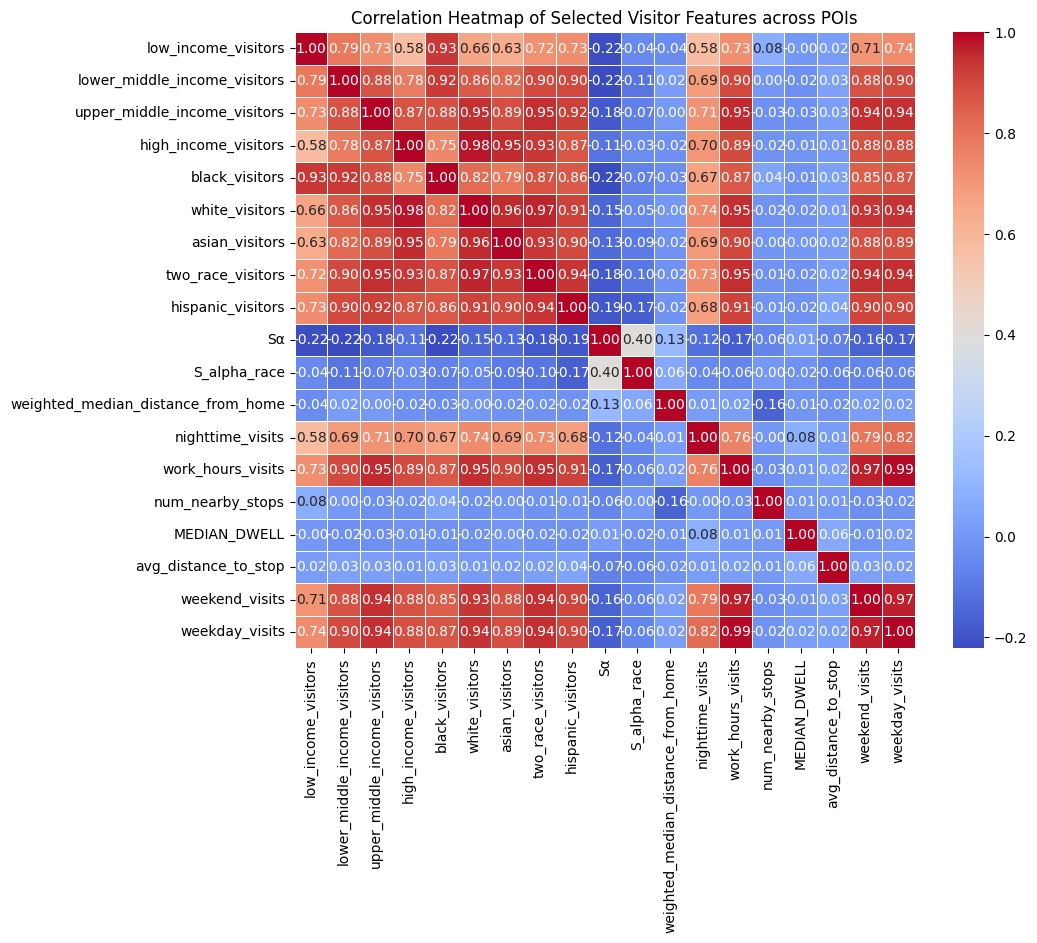

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_columns = ['low_income_visitors','lower_middle_income_visitors','upper_middle_income_visitors','high_income_visitors',
                       'black_visitors','white_visitors','asian_visitors','two_race_visitors','hispanic_visitors','Sα',
                       'S_alpha_race', 'weighted_median_distance_from_home', 'nighttime_visits',
    'work_hours_visits', 'num_nearby_stops', 'MEDIAN_DWELL', 'avg_distance_to_stop',
    'weekend_visits', 'weekday_visits']
correlation_matrix = df[correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Visitor Features across POIs")
plt.show()


In [ ]:
income_quantiles = df["income_quantile"].unique()
for quantile in income_quantiles:
    subset_df = df[df["income_quantile"] == quantile]
    correlation_matrix = subset_df[correlation_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap for Income Quantile: {quantile}")
    plt.show()

In [ ]:
full=mp[mp['Sα']==1]
full['place_subcategory'].value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(cbg_gdf['Si'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced income segregation Values Across cbgs')
plt.xlabel('Si')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(cbg_gdf['Si_q'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced income segregation Values Across cbgs')
plt.xlabel('Si')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(cbg_gdf['Si_race'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced racial segregation Values Across cbgs')
plt.xlabel('Si_race')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(cbg_gdf['Si_race_v2'].dropna(), bins=30, kde=True)
plt.title('Distribution of experienced racial segregation Values Across cbgs')
plt.xlabel('Si_race_v2')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(mp['Sα'].dropna(), bins=30, kde=True)
plt.title('Distribution of income segregation Values Across places')
plt.xlabel('Sα')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(mp['Sα_q'].dropna(), bins=30, kde=True)
plt.title('Distribution of income segregation Values Across places')
plt.xlabel('Sα')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(mp['S_alpha_race'].dropna(), bins=30, kde=True)
plt.title('Distribution of race segregation Values Across places')
plt.xlabel('S_alpha_race')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(mp['S_alpha_race_v2'].dropna(), bins=30, kde=True)
plt.title('Distribution of race segregation Values Across places')
plt.xlabel('S_alpha_race_v2')
plt.ylabel('Frequency')
plt.show()


In [ ]:
mp.dropna(subset='Sα',inplace=True,ignore_index=True)

In [ ]:
def aggregate_visits(mp):
    df = mp.drop_duplicates(subset='adjusted_cbg_visitors', ignore_index=True)

    expanded_rows = df.apply(lambda row: pd.DataFrame(list(row['adjusted_cbg_visitors'].items()), columns=['cbg', 'visitor_count']).assign(place_category=row['place_category'], place_subcategory=row['place_subcategory']), axis=1)

    exploded_df = pd.concat(expanded_rows.tolist(), ignore_index=True)
    exploded_df['visitor_count'] = pd.to_numeric(exploded_df['visitor_count'])
    grouped = exploded_df.groupby(['cbg', 'place_category', 'place_subcategory'], as_index=False)['visitor_count'].sum()
    top_subcategories = (grouped.groupby('place_category')['place_subcategory'].value_counts().groupby(level=0).head(5).index.get_level_values(1))

    grouped_filtered = grouped[grouped['place_subcategory'].isin(top_subcategories)]

    aggregated_df = grouped_filtered.pivot(index=['cbg', 'place_category'],
                                           columns='place_subcategory',
                                           values='visitor_count').fillna(0)

    aggregated_df.reset_index(inplace=True)

    return aggregated_df

agg_df = aggregate_visits(mp)

agg_df['cbg'] = agg_df['cbg'].astype(str).str.lstrip("0").astype(int)
cbg_gdf['cbg'] = cbg_gdf['cbg'].astype(str).str.lstrip("0").astype(int)

agg_df = pd.merge(agg_df, cbg_gdf[['cbg', 'ALAND', 'tot_pop', 'hispanic_pop', 'white_pop', 'black_pop',
                                   'american_indian_pop', 'asian_pop', 'hawaiian_pop', 'other_race_pop',
                                   'two_race_pop', 'commuting_pop', 'working_walked', 'working_transit',
                                   'median_hh_income', 'income_quantile', 'pop_in_hh', 'no_veh_pop',
                                   'tot_18_to_65', 'below_poverty', 'with_disability', 'unemployment_pop',
                                   'number_devices_residing', 'geometry']], on='cbg', how='inner')



In [ ]:
quantile_edges = mp['income_segregation'].quantile([0.2, 0.4, 0.6, 0.8, 1.0]).values
labels = ['HS-Lo', 'MS-Lo', 'LS', 'MS-Hi', 'HS-Hi']
def assign_segregation_group(ice_value, quantiles):
    if ice_value <= quantiles[0]:
        return 'HS-Lo'
    elif ice_value <= quantiles[1]:
        return 'MS-Lo'
    elif ice_value <= quantiles[2]:
        return 'LS'
    elif ice_value <= quantiles[3]:
        return 'MS-Hi'
    else:
        return 'HS-Hi'

mp['income_segregation_group'] = mp['income_segregation'].apply(lambda x: assign_segregation_group(x, quantile_edges))
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
palette=sns.color_palette("husl", 9)
sns.boxplot(data=mp, x='place_income_segregation_group', y='income_segregation', order=['HS-Lo', 'MS-Lo', 'LS', 'MS-Hi', 'HS-Hi'],palette=palette)

plt.title('Distribution of ICE Values Within Each Segregation Group')
plt.xlabel('Segregation Group')
plt.ylabel('ICE_income')
plt.xticks(rotation=45)

plt.show()


array([0.32579086, 0.4395479 , 0.60600059, 0.7381761 , 1.        ])

In [ ]:
def compute_dominant_attributes(mp):
    def get_dominant(dictionary: dict) -> str:
        if not dictionary or not isinstance(dictionary, dict):
            return None
        # Get the key with maximum value
        return max(dictionary, key=dictionary.get)

    # Apply the function to extract dominant race and income quantile.
    mp = mp.copy()
    mp['dominant_race'] = mp['racial_weighted_means'].apply(get_dominant)
    mp['dominant_income_quantile'] = mp['quartile_proportions'].apply(get_dominant)

    return mp

mp=compute_dominant_attributes(mp)
mp

,PLACEKEY,PARENT_PLACEKEY,LOCATION_NAME,RAW_VISIT_COUNTS,address,RAW_VISITOR_COUNTS,VISITS_BY_DAY,VISITOR_HOME_CBGS,MEDIAN_DWELL,POI_CBG,SAFEGRAPH_BRAND_IDS,BRANDS,STORE_ID,TOP_CATEGORY,SUB_CATEGORY,CATEGORY_TAGS,NAICS_CODE,LATITUDE,LONGITUDE,STREET_ADDRESS,CITY,REGION,POSTAL_CODE,OPEN_HOURS,OPENED_ON,CLOSED_ON,TRACKING_CLOSED_SINCE,WEBSITES,GEOMETRY_TYPE,POLYGON_WKT,POLYGON_CLASS,ENCLOSED,PHONE_NUMBER,IS_SYNTHETIC,INCLUDES_PARKING_LOT,ISO_COUNTRY_CODE,WKT_AREA_SQ_METERS,DATE_RANGE_START,DATE_RANGE_END,VISITOR_HOME_AGGREGATION,VISITOR_DAYTIME_CBGS,VISITOR_COUNTRY_OF_ORIGIN,DISTANCE_FROM_HOME,BUCKETED_DWELL_TIMES,RELATED_SAME_DAY_BRAND,RELATED_SAME_MONTH_BRAND,POPULARITY_BY_HOUR,POPULARITY_BY_DAY,DEVICE_TYPE,NORMALIZED_VISITS_BY_STATE_SCALING,NORMALIZED_VISITS_BY_REGION_NAICS_VISITS,NORMALIZED_VISITS_BY_REGION_NAICS_VISITORS,NORMALIZED_VISITS_BY_TOTAL_VISITS,NORMALIZED_VISITS_BY_TOTAL_VISITORS,geometry,parent_flag,nearby_stops,nearby_stop_distances,num_nearby_stops,three_cat_label,place_category,place_subcategory,adjusted_cbg_visitors,early_morning_visits,breakfast_visits,morning_work_hours_visits,lunch_visits,afternoon_visits,dinner_visits,nighttime_visits,work_hours_visits,popularity_by_hour_sum,visitor_counts_cbg_scaled,visits_per_visitor,adjusted_visits_by_day,adjusted_popularity_by_day,adjusted_raw_visit_counts,merged_flag,weighted_median_distance_from_home,median_distance_from_home,avg_distance_to_stop,racial_weighted_means,income_weighted_means,Sα,quartile_proportions,S_alpha_race,S_alpha_race_v2,weekday_visits,weekend_visits,cbg,income_quantile,upweighting_factor,entropy_measure,Hα,Iα,dominant_race,dominant_income_quantile
0,224-222@8gk-ttq-sdv,NaN,The Summit Birmingham,83726.0,"214 Summit Blvd, Vestavia, AL 35243.0, US",46329.0,"[3205,2979,1673,2483,2469,2452,1705,3566,3786,...","{""010730128032"":628,""010730027001"":331,""010730...",56.0,10730128032,NaN,NaN,60356.0,Lessors of Real Estate,Malls,NaN,531120.0,33.447464,-86.729987,214 Summit Blvd,Vestavia,AL,35243,NaN,NaN,NaN,NaN,NaN,POLYGON,POLYGON ((-86.73102151403035 33.45258337253362...,OWNED_POLYGON,False,NaN,False,True,US,468598.0,2023-12-01 00:00:00.000,2024-01-01 00:00:00.000,"{""01073012803"":879,""01073010805"":491,""01117030...","{""010730128032"":628,""010730027001"":514,""010730...","{""US"":35921}",NaN,"{ ""<5"":21110, ""5-20"":10907, ""21-60"":18313, ""61...","{""Shell Oil"":7132,""LensCrafters"":6091,""Starbuc...","{""Walmart"":28461,""Walmart Pharmacy"":28150,""Jac...","[342, 195, 342, 151, 236, 492, 746, 2244, 2469...","{'Monday': 9013, 'Tuesday': 9297, 'Wednesday':...","{""ios"":17386,""android"":8843}",1126299.0,0.529380,0.992124,0.031463,0.289553,POINT (525095.435 3700927.223),1,['Summit Blvd & Summit Place'],[67.98136328987707],1,Lessors of Real Estate-Malls,Discretionary Retail,Mall,"{10730128032: 20167.897136259216, 10730027001:...",1758,9796,21523,32997,50773,40859,15860,34909.720049,173566,752520.499386,1.807205,"[52059, 48388, 27174, 40331, 40104, 39828, 276...","[5555, 3167, 5555, 2453, 3833, 7992, 12117, 36...",1359959,False,9046.647083,17034.124788,67.981363,"{'white_pop_frac': 0.7212170420756927, 'black_...","{'less_than_10k': 37.59133308948238, '10k_15k'...",0.403270,"{'low': 0.06819497393325662, 'lower_middle': 0...",0.701275,0.126363,55269,28457,1.073013e+10,high,14.172131,0.812723,0.812723,0.653694,white_pop_frac,high
1,zzw-22m@8gk-twj-q75,NaN,Riverchase Galleria,55829.0,"2000 Riverchase Galleria, Hoover, AL, 35244, US",35122.0,"[2212,2223,1958,1120,1231,1350,1341,2124,3098,...","{""010730144081"":595,""010730143021"":287,""010730...",61.0,10730144081,NaN,NaN,81871.0,Lessors of Real Estate,Malls,NaN,531120.0,33.379499,-86.808083,2000 Riverchase Galleria,Hoover,AL,35244,NaN,NaN,NaN,NaN,NaN,POLYGON,"POLYGON ((-86.8117560115864 33.37995733211166,...",OWNED_POLYGON,False,1.205985e+10,False,True,US,291768.0,2023-12-01 00:00:00.000,2024-01-01 00:00:00.000,"{""01073014408"":684,""01073014413"":518,""01073014...","{""010730144081"":937,""010730

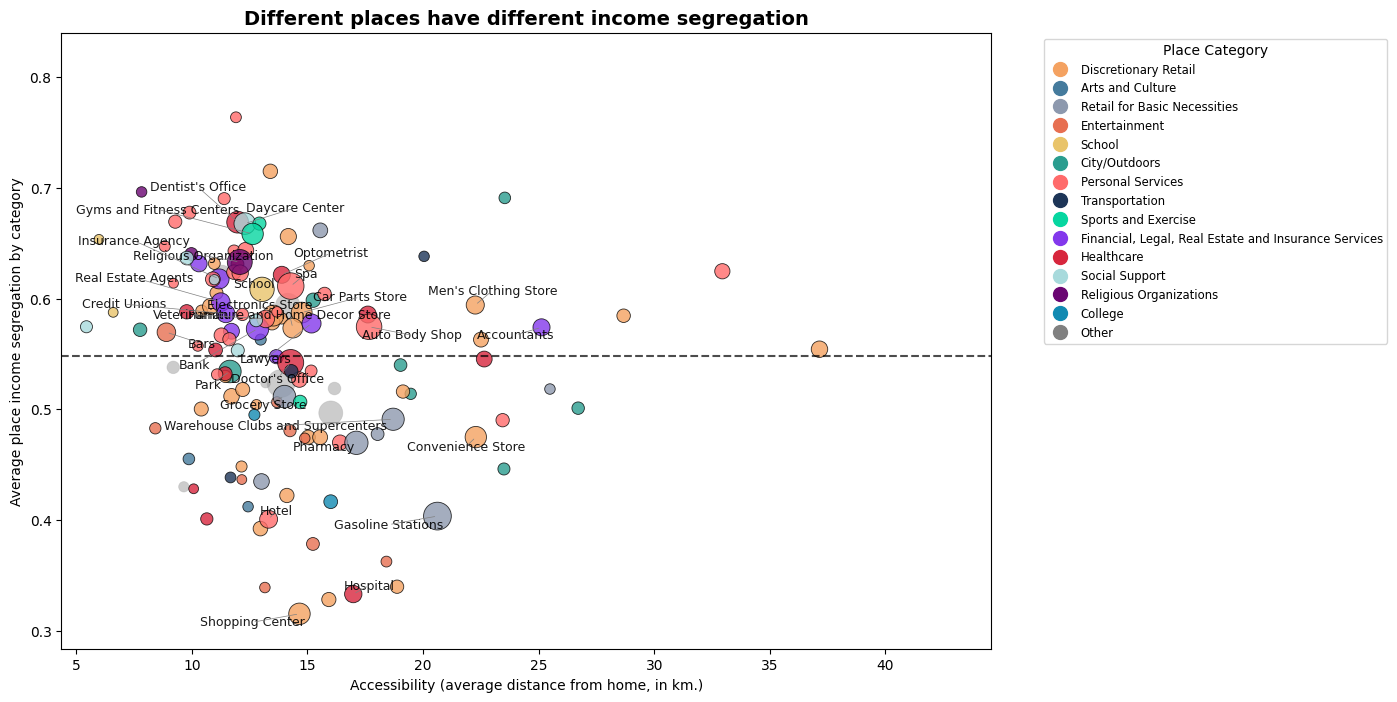

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # Smart label adjustment

# Convert distance to kilometers
mp['median_distance_from_home_km'] = mp['median_distance_from_home'] / 1000

# Compute aggregated statistics
table_cats = (
    mp.groupby(["place_category","place_subcategory"])
    .agg(
        nplaces=("place_category", "count"),
        nvisits=("adjusted_raw_visit_counts", "mean"),
        nuusers=("visitor_counts_cbg_scaled", "mean"),
        avg_dist=("median_distance_from_home_km", lambda x: np.sum(x * mp.loc[x.index, "adjusted_raw_visit_counts"]) / np.sum(mp.loc[x.index, "adjusted_raw_visit_counts"])),
        avg_inc_seg=("income_segregation", "mean"),
    )
    .reset_index()
    .sort_values(by="place_category")
)

# Define selected taxonomies
selected_taxonomies = {
    "Discretionary Retail", "Arts and Culture", "Retail for Basic Necessities",
    "Entertainment", "School", "City/Outdoors", "Personal Services","Transportation","Sports and Exercise","Financial, Legal, Real Estate and Insurance Services",
    "Healthcare", "Social Support", "Religious Organizations","College"
}
table_cats["tax"] = table_cats["place_category"].apply(lambda x: x if x in selected_taxonomies else "Other")

tt = table_cats[table_cats["nplaces"] > 5]

custom_palette = {
    "Discretionary Retail": "#F4A261",  # Orange
    "Arts and Culture": "#457B9D",  # Blue
    "Retail for Basic Necessities": "#8D99AE",  # Grayish blue
    "Entertainment": "#E76F51",  # Red
    "School": "#E9C46A",  # Yellow
    "City/Outdoors": "#2A9D8F",  # Teal green
    "Personal Services": "#FF6B6B",  # Coral pink
    "Transportation": "#1D3557",  # Deep navy blue
    "Sports and Exercise": "#06D6A0",  # Bright green
    "Financial, Legal, Real Estate and Insurance Services": "#8338EC",  # Vibrant purple
    "Healthcare": "#D7263D",  # Deep red
    "Social Support": "#A8DADC",  # Light blue
    "Religious Organizations": "#6A0572",  # Dark purple
    "College": "#118AB2",  # Rich cyan blue
    "Other": "gray"  # Generic gray for uncategorized entries
}
# Set figure size
plt.figure(figsize=(12, 8))

# Plot "Other" category with reduced visibility
sns.scatterplot(
    data=tt[tt["tax"] == "Other"],
    x="avg_dist",
    y="avg_inc_seg",
    size=np.sqrt(tt[tt["tax"] == "Other"]["nplaces"]),
    sizes=(50, 400),  # Smaller scaling range
    color="gray",
    alpha=0.4,  # Reduce visibility
    edgecolor="darkgray"
)

# Plot selected taxonomy categories
sns.scatterplot(
    data=tt[tt["tax"] != "Other"],
    x="avg_dist",
    y="avg_inc_seg",
    hue="tax",
    size=np.sqrt(tt[tt["tax"] != "Other"]["nplaces"]),
    sizes=(50, 400),  # Smaller scaling range
    palette=custom_palette,
    edgecolor="black",
    alpha=0.8,
    legend=False  # Disable Seaborn's automatic legend
)

# Draw a horizontal dashed line for the average place income segregation
plt.axhline(y=mp["income_segregation"].mean(), linestyle="dashed", color="black", alpha=0.7)

#plt.xscale("log")
plt.xlim(tt["avg_dist"].min() * 0.8, tt["avg_dist"].max() * 1.2)  # Auto scaling for better fit
plt.ylim(tt["avg_inc_seg"].min() * 0.9, tt["avg_inc_seg"].max() * 1.1)  # Auto scaling for better fit
plt.xlabel("Accessibility (average distance from home, in km.)")
plt.ylabel("Average place income segregation by category")
plt.title("Different places have different income segregation", fontsize=14, fontweight="bold")

# Adjusted legend placement to avoid pushing plot left
handles = [plt.Line2D([], [], marker="o", linestyle="", color=color, markersize=10, label=label)
           for label, color in custom_palette.items()]
plt.legend(handles=handles, title="Place Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")

### AUTOMATIC LABELING OF TOP CATEGORIES WITHOUT CLUTTER ###
texts = []  # List to store text labels

# Select top categories dynamically
top_labels = pd.concat([
    tt[tt["tax"] != "Other"].nlargest(30, "nplaces"),  # Most frequent categories
]).drop_duplicates()

# Loop through selected labels and annotate
for _, row in top_labels.iterrows():
    texts.append(
        plt.text(
            row["avg_dist"], row["avg_inc_seg"], row["place_subcategory"],
            fontsize=9, color="black", alpha=0.9, ha="right"
        )
    )

# Adjust text labels to prevent overlap and spread them more
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
            expand_points=(1.3, 1.4),  # Spread out labels more
            force_text=(0.2, 0.5),  # Push labels away if necessary
            only_move={'points': 'y', 'text': 'xy'})  # Allow both x and y movements

# Show plot
plt.show()


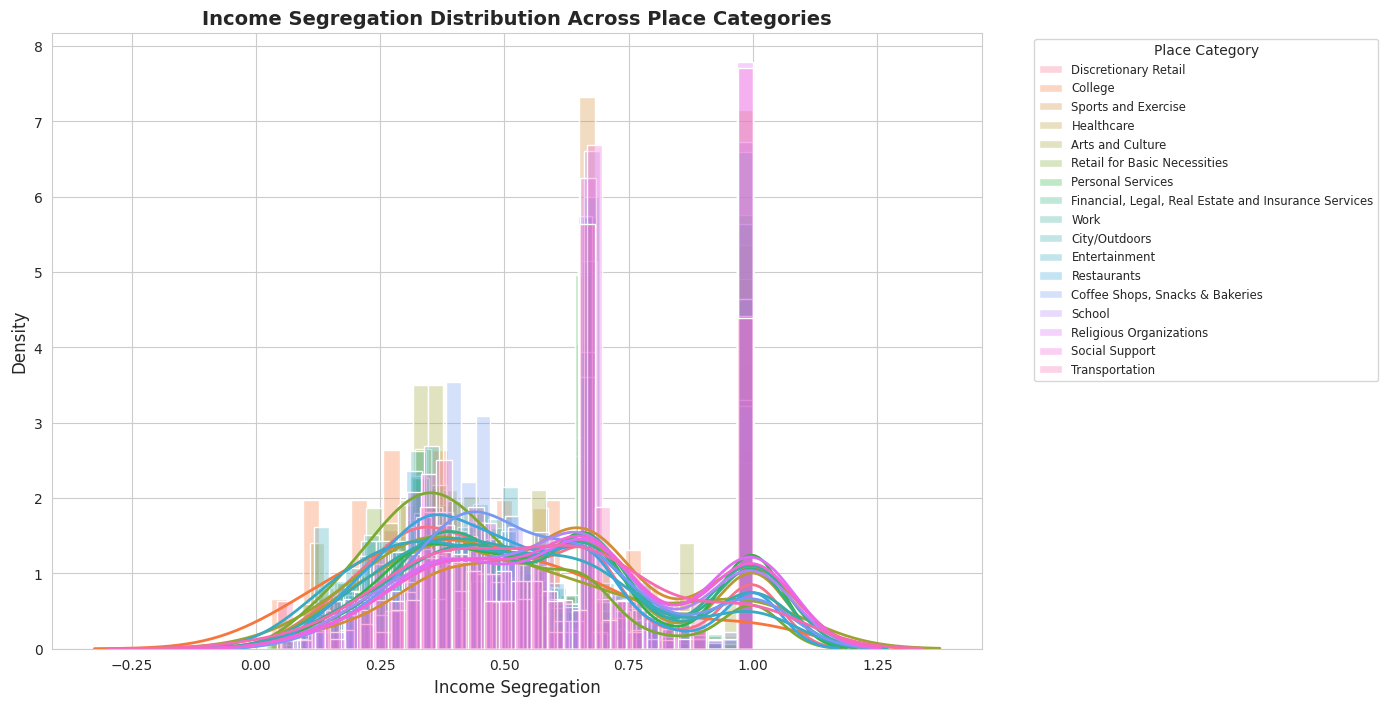

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

place_categories = mp["place_category"].unique()

plt.figure(figsize=(12, 8))

palette = sns.color_palette("husl", len(place_categories))  # Husl ensures good color variety

# Plot histogram + KDE for each place category
for i, category in enumerate(place_categories):
    subset = mp[mp["place_category"] == category]["income_segregation"]

    # Plot histogram
    sns.histplot(subset, bins=30, color=palette[i], alpha=0.3, stat="density", label=category)

    # Plot KDE separately
    sns.kdeplot(subset, color=palette[i], lw=2)

# Labels and title
plt.xlabel("Income Segregation", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Income Segregation Distribution Across Place Categories", fontsize=14, fontweight="bold")

# Add legend outside the plot
plt.legend(title="Place Category", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")

# Show the plot
plt.show()
